In [4]:
import rasterio as rio
import numpy as np

In [2]:
with rio.open('outputs/rf_full_2019.tif') as src:
    ghana_2019 = src.read()
    profile = src.profile
    src.close()
    
with rio.open('outputs/rf_full_2020.tif') as src:
    ghana_2020 = src.read()
    src.close()
    
with rio.open('outputs/rf_full_2021.tif') as src:
    ghana_2021 = src.read()
    src.close()
    
with rio.open('outputs/rf_full_2022.tif') as src:
    ghana_2022 = src.read()
    src.close()

In [5]:
cd = np.zeros(np.squeeze(ghana_2019).shape)

(2158, 3122)

In [6]:
lulc_dict = dict((
    ("Forest", 0),
    ("Grassland", 1),
    ("Urban", 2),
    ("Bare", 3),
    ("Water", 4),
))

In [12]:
cd = np.where((ghana_2019 == 0) & (ghana_2020 == 2) | (ghana_2019 == 0) & (ghana_2020 == 3), 1, cd)

In [16]:
cd = np.zeros(np.squeeze(ghana_2019).shape)

cd = np.where((ghana_2019 == 0) & (ghana_2020 == 2) | (ghana_2019 == 0) & (ghana_2020 == 3) | \
              (ghana_2019 == 1) & (ghana_2020 == 2) | (ghana_2019 == 1) & (ghana_2020 == 3), 1, cd)

cd = np.where((ghana_2020 == 0) & (ghana_2021 == 2) | (ghana_2020 == 0) & (ghana_2021 == 3) | \
              (ghana_2020 == 1) & (ghana_2021 == 2) | (ghana_2020 == 1) & (ghana_2021 == 3), 2, cd)

cd = np.where((ghana_2021 == 0) & (ghana_2022 == 2) | (ghana_2021 == 0) & (ghana_2022 == 3) | \
              (ghana_2021 == 1) & (ghana_2022 == 2) | (ghana_2021 == 1) & (ghana_2022 == 3), 3, cd)

cd

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

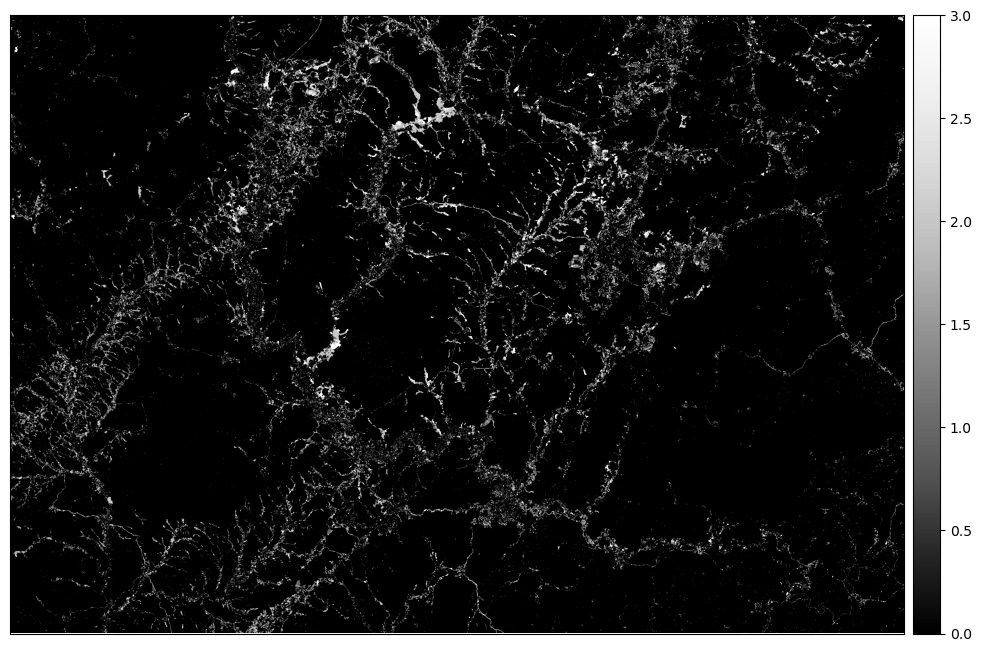

<Axes: >

In [17]:
import earthpy.plot as ep

ep.plot_bands(cd)

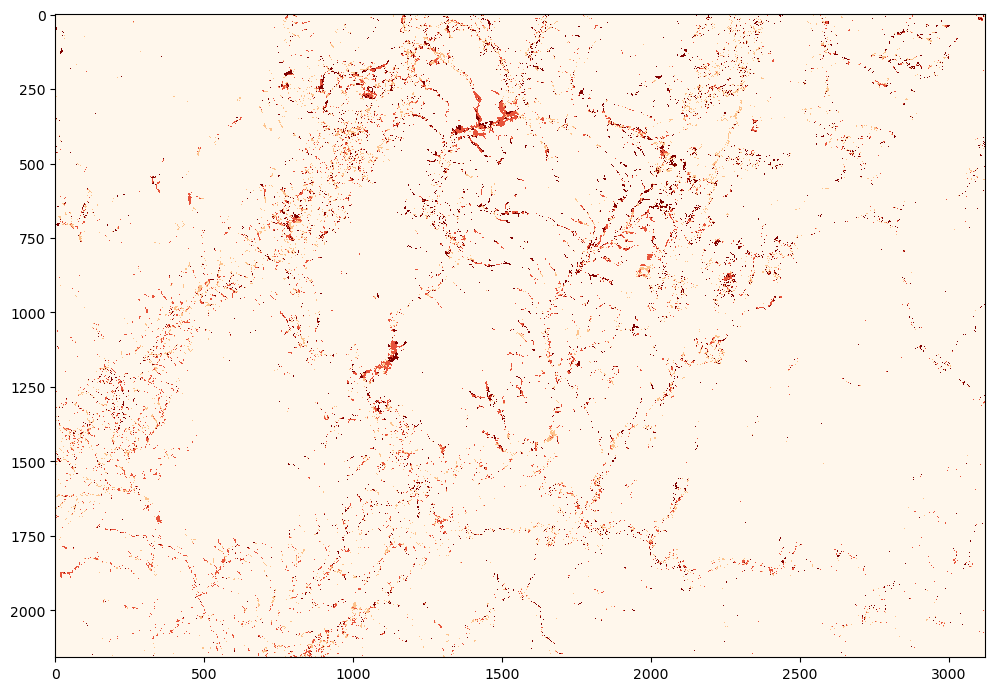

In [27]:
from scipy.ndimage import median_filter
from skimage.morphology import disk, ball, cube, rectangle
import matplotlib.pyplot as plt

ball_array = median_filter(np.squeeze(cd), footprint = ball(1)[1])

f, ax = plt.subplots(figsize = (12,12))
ax.imshow(ball_array, cmap = "OrRd", interpolation='nearest')

In [20]:
with rio.open('outputs/deforestation.tif', "w", **profile) as dst:
    dst.write(cd.astype(np.int8))
    dst.close()

In [18]:
profile

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 3122, 'height': 2158, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(30.0, 0.0, 582360.0,
       0.0, -30.0, 710910.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [28]:
with rio.open('outputs/deforestation_filtered.tif', "w", **profile) as dst:
    dst.write(np.expand_dims(ball_array, axis = 0).astype(np.int8))
    dst.close()

## Regrowth

In [29]:
rg = np.zeros(np.squeeze(ghana_2019).shape)

rg = np.where((ghana_2019 == 3) & (ghana_2020 == 0) | (ghana_2019 == 2) & (ghana_2020 == 1) | \
              (ghana_2019 == 3) & (ghana_2020 == 1) | (ghana_2019 == 2) & (ghana_2020 == 0), 1, rg)

rg = np.where((ghana_2020 == 3) & (ghana_2021 == 0) | (ghana_2020 == 2) & (ghana_2021 == 1) | \
              (ghana_2020 == 3) & (ghana_2021 == 1) | (ghana_2020 == 2) & (ghana_2021 == 0), 2, rg)

rg = np.where((ghana_2021 == 3) & (ghana_2022 == 0) | (ghana_2021 == 2) & (ghana_2022 == 1) | \
              (ghana_2021 == 3) & (ghana_2022 == 1) | (ghana_2021 == 2) & (ghana_2022 == 0), 3, rg)

rg

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

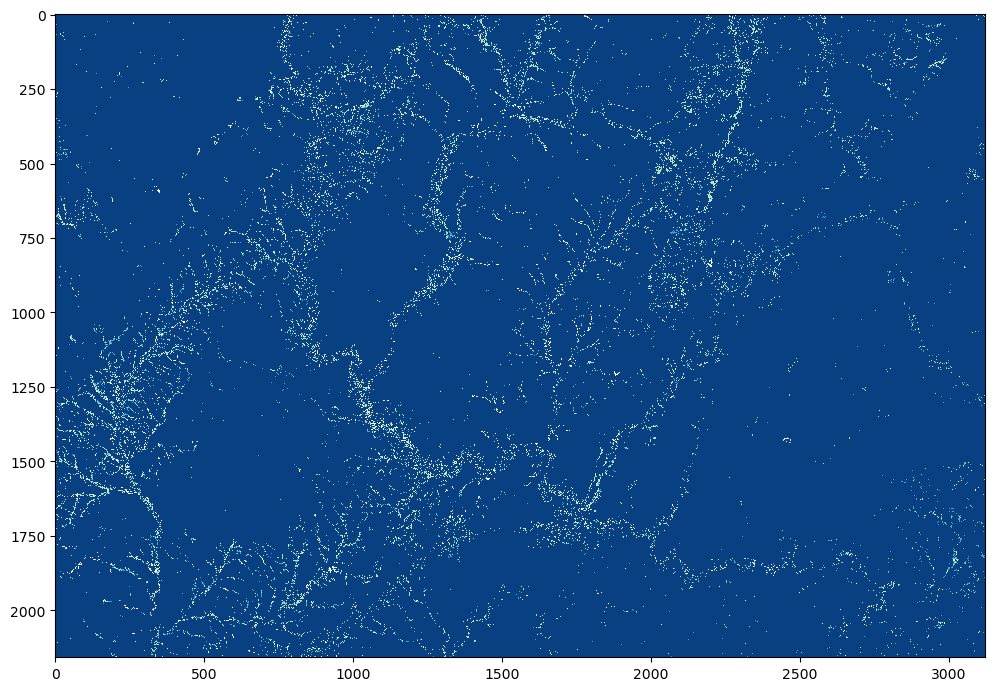

In [32]:
f, ax = plt.subplots(figsize = (12,12))
ax.imshow(np.squeeze(rg), cmap = "GnBu_r", interpolation='nearest')

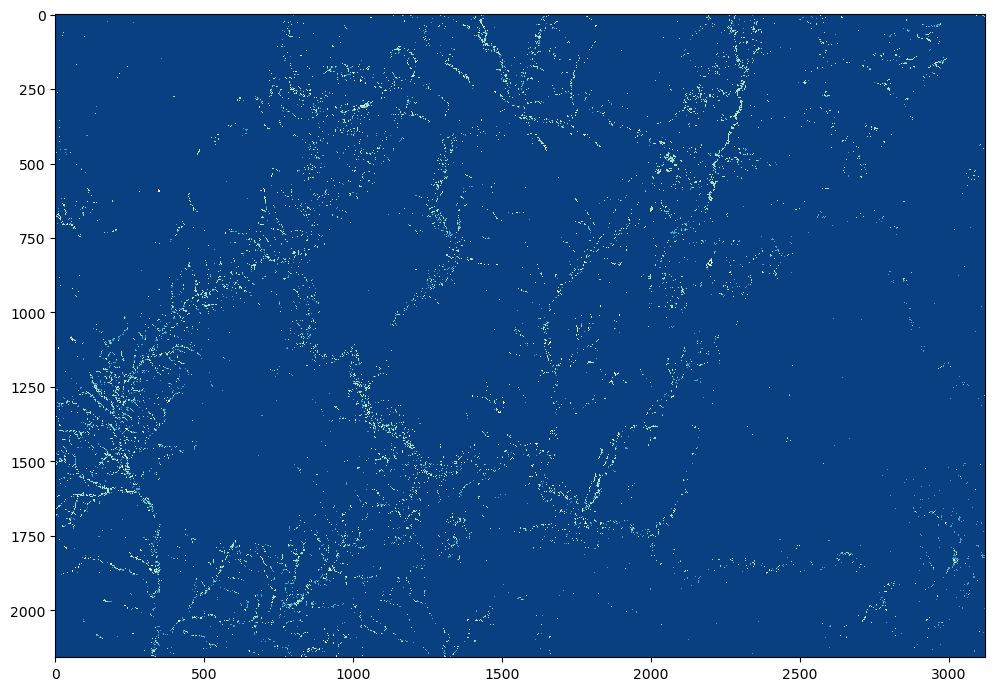

In [33]:
from scipy.ndimage import median_filter
from skimage.morphology import disk, ball, cube, rectangle
import matplotlib.pyplot as plt

ball_rg = median_filter(np.squeeze(rg), footprint = ball(1)[1])

f, ax = plt.subplots(figsize = (12,12))
ax.imshow(ball_rg, cmap = "GnBu_r", interpolation='nearest')

In [34]:
with rio.open('outputs/regrowth.tif', "w", **profile) as dst:
    dst.write(rg.astype(np.int8))
    dst.close()
    
with rio.open('outputs/regrowth_filtered.tif', "w", **profile) as dst:
    dst.write(np.expand_dims(ball_rg, axis = 0).astype(np.int8))
    dst.close()

## Issues

One issue is that might be some anomalies that lead to incorrect mapping. For example: 

 - 2019: Bare
 - 2020: Bare
 - 2021: Forest
 - 2022: Bare

In this case, the current algorithm marks 2020-2021 as regrowth, and 2021-2022 as deforestation, whereas the likely outcome is that Forest was misclassified in 2021.

Consider requiring two years in a row to be the same to mark it down?